In [18]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import  LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, Sequential
from sklearn.preprocessing import StandardScaler
%matplotlib inline
sns.set(style="whitegrid",
        palette='muted', font_scale=1.5)
rcParams['figure.figsize']=14, 8
RANDOM_SEED= 42
LABELS = ["Normal", "Fraud"]

In [6]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.shape
df.isnull().values.any()

False

<ipython-input-9-1ac70c04728e>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort=True)


Text(0, 0.5, 'Frequency')

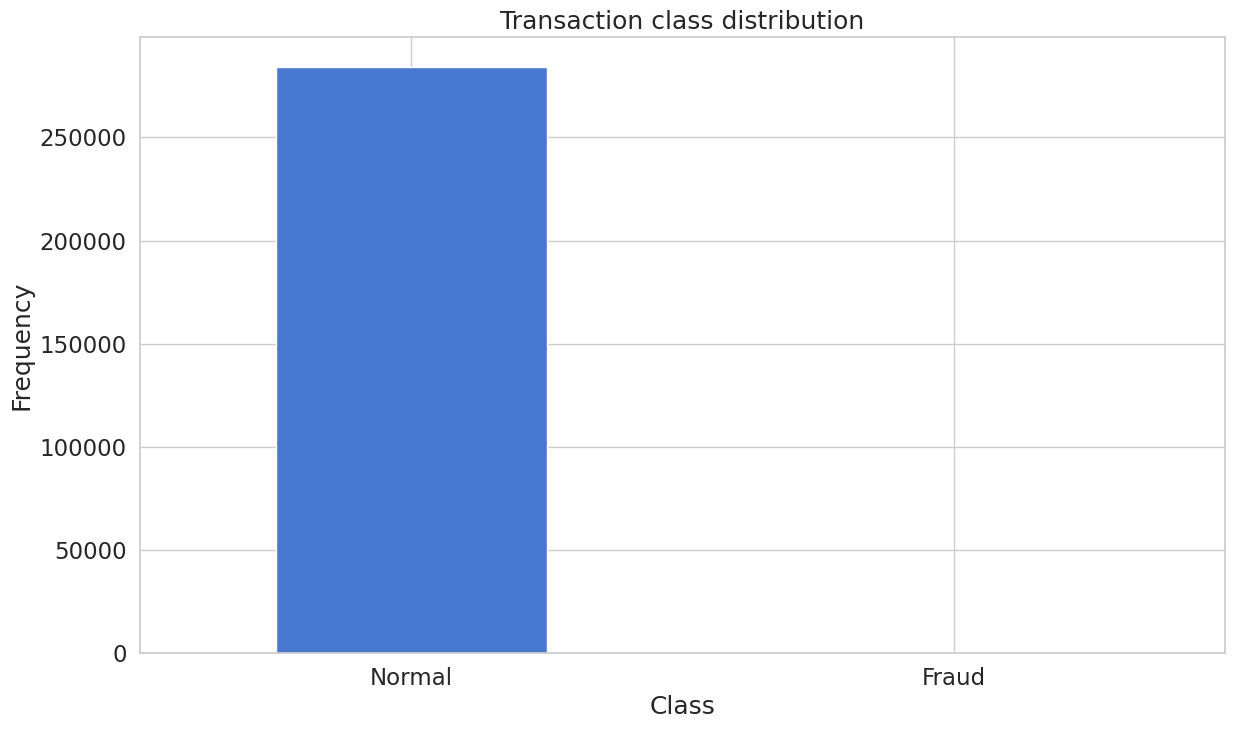

In [9]:
#Checking the number of records of each kind of transaction class (Fraud and Normal)
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind = "bar", rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [10]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [11]:
normal.shape

(284315, 31)

In [12]:
#check the amount of money involved in each kind of transaction
#Fraud transactions
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [13]:
#Normal transactions
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

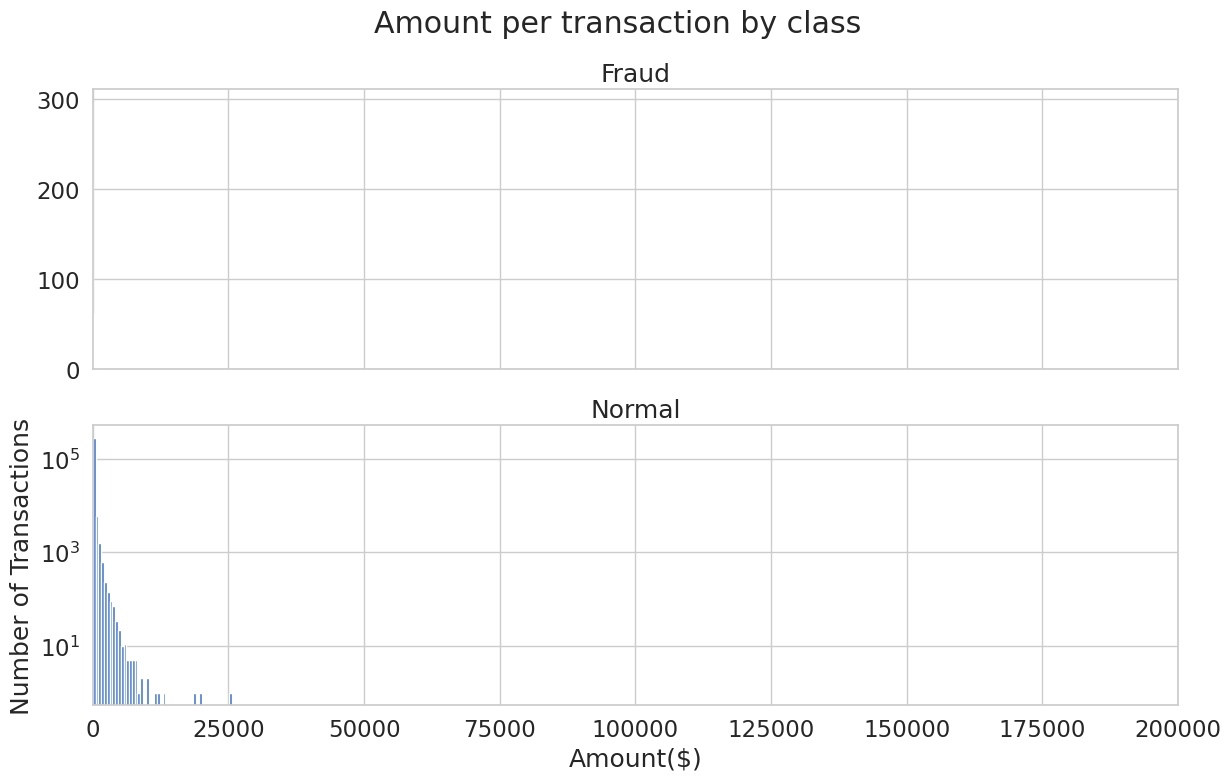

In [14]:
#Representation of Amount
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle("Amount per transaction by class")
bins=50
ax1.hist(frauds.Amount, bins=bins)
ax1.set_title("Fraud")

ax2.hist(normal.Amount, bins = bins)
ax2.set_title("Normal")

plt.xlabel("Amount($)")
plt.ylabel("Number of Transactions")
plt.xlim((0, 200000))
plt.yscale('log')
plt.show()

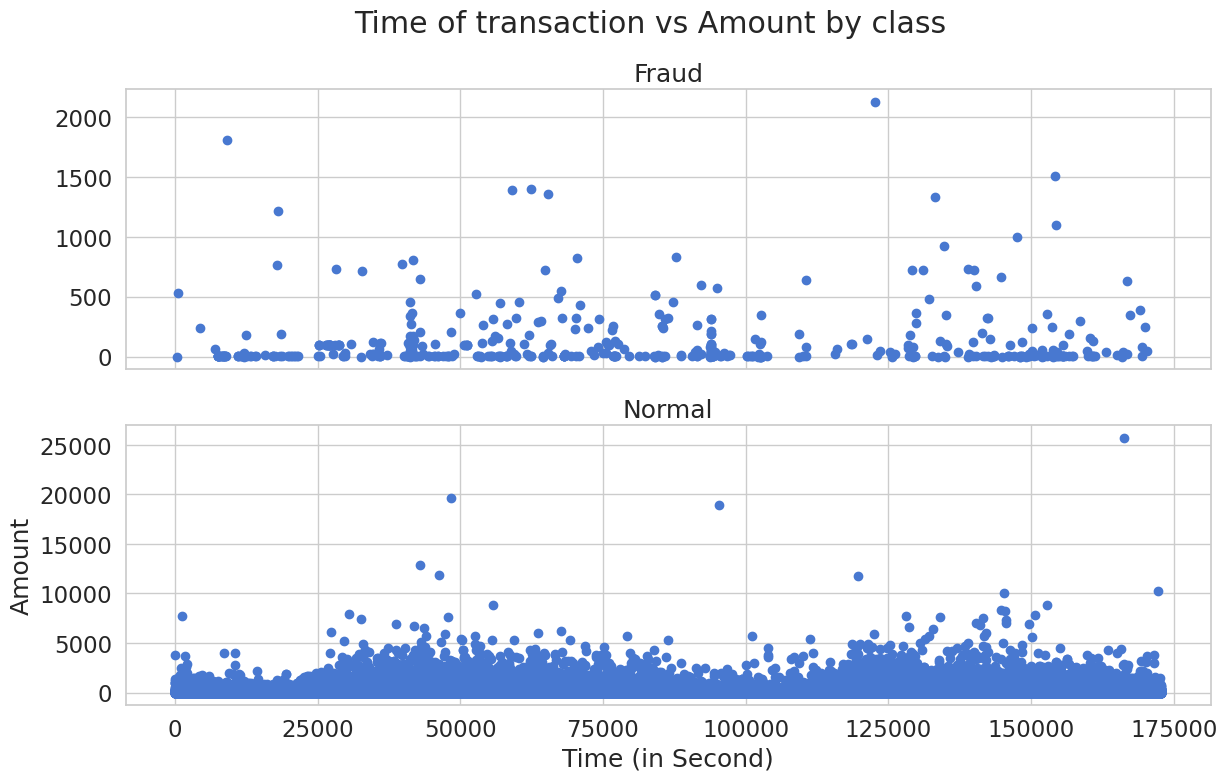

In [16]:
#Plotting the time of transaction to check the correlation
f, (ax1,ax2) = plt.subplots(2, 1,sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title("Fraud")

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title("Normal")

plt.xlabel("Time (in Second)")
plt.ylabel("Amount")
plt.show()

In [17]:
data = df.drop(['Time'], axis=1)


In [19]:
#Scalling The Amount using StandardScaler
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [21]:
#Building the Model
non_fraud = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]

# Concatenate non-fraud and fraud dataframes
df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)

X = df.drop(['Class'], axis=1).values
Y = df['Class'].values

In [22]:
#Split the data into 80% Train and 20% testing
x_train, x_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
x_train_fraud = x_train[x_train.Class == 1]
x_train = x_train[x_train.Class == 0]
x_train = x_train.drop(['Class'], axis=1)
y_test = x_test['Class']
x_test = x_test.drop(['Class'], axis=1)
x_train = x_train.values
x_train.shape

(227451, 29)

In [24]:
#AutoEncoder Model
input_layer = Input(shape=(X.shape[1],))
# encoding part
encoded = Dense(100, activation= 'tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50,activation='relu')(encoded)

#Decoding part
decoded=Dense(50,activation="tanh")(encoded)
decoded = Dense(100, activation="tanh")(decoded)

 #output layer
output_layer = Dense(X.shape[1], activation="relu")(decoded)

In [25]:
#Training the model
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [28]:
#Scalling the values
X= data.drop(["Class"], axis=1)
Y = data["Class"].values

x_scale = MinMaxScaler().fit_transform(X.values)
x_norm, x_fraud = x_scale[Y ==0], x_scale[Y==1]

autoencoder.fit(x_norm[0:2000],x_norm[0:2000],
                batch_size= 256, epochs=10,
                shuffle=True, validation_split = 0.20
                )

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.9357 - val_loss: 0.8305
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9353 - val_loss: 0.8300
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9347 - val_loss: 0.8294
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9342 - val_loss: 0.8289
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9336 - val_loss: 0.8283
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9330 - val_loss: 0.8278
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9321 - val_loss: 0.8272
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9316 - val_loss: 0.8266
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9313 - val_loss: 0.8260
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9302 - val_loss: 0.8255


In [29]:
#The Hidden Representation
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [30]:
#Model Prediction
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [31]:
#Getting the representation Data
rep_x= np.append(norm_hid_rep, fraud_hid_rep, axis=0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [32]:
#Train,Test
train_x, val_x, train_y,val_y = train_test_split(rep_x, rep_y, test_size=0.25)

In [33]:
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print("Classification Report: ")
print(classification_report(val_y, pred_y))

print("")
print("Accuracy Score: ",accuracy_score)


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       746
         1.0       0.99      0.73      0.84       127

    accuracy                           0.96       873
   macro avg       0.97      0.87      0.91       873
weighted avg       0.96      0.96      0.96       873


Accuracy Score:  <function accuracy_score at 0x79ec7d573a30>
